# Download Dataset


In [4]:
# Download the KITTI dataset
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2025-03-10 01:12:23--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 

3.5.136.174, 3.5.135.10, 52.219.169.197, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  16.2MB/s    in 16s     

2025-03-10 01:12:39 (19.4 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



# Import Libraries

In [5]:
!unzip data_semantics.zip

Archive:  data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating: testing/image_2/000005_10.png  
  inflating: testing/image_2/000006_10.png  
  inflating: testing/image_2/000007_10.png  
  inflating: testing/image_2/000008_10.png  
  inflating: testing/image_2/000009_10.png  
  inflating: testing/image_2/000010_10.png  
  inflating: testing/image_2/000011_10.png  
  inflating: testing/image_2/000012_10.png  
  inflating: testing/image_2/000013_10.png  
  inflating: testing/image_2/000014_10.png  
  inflating: testing/image_2/000015_10.png  
  inflating: testing/image_2/000016_10.png  
  inflating: testing/image_2/000017_10.png  
  inflating: testing/image_2/000018_10.png  
  inflating: testing/image_2/000019_10.png  
  inflating: testin


  inflating: testing/image_2/000024_10.png  
  inflating: testing/image_2/000025_10.png  
  inflating: testing/image_2/000026_10.png  
  inflating: testing/image_2/000027_10.png  
  inflating: testing/image_2/000028_10.png  
  inflating: testing/image_2/000029_10.png  
  inflating: testing/image_2/000030_10.png  
  inflating: testing/image_2/000031_10.png  
  inflating: testing/image_2/000032_10.png  
  inflating: testing/image_2/000033_10.png  
  inflating: testing/image_2/000034_10.png  
  inflating: testing/image_2/000035_10.png  
  inflating: testing/image_2/000036_10.png  
  inflating: testing/image_2/000037_10.png  
  inflating: testing/image_2/000038_10.png  
  inflating: testing/image_2/000039_10.png  
  inflating: testing/image_2/000040_10.png  
  inflating: testing/image_2/000041_10.png  
  inflating: testing/image_2/000042_10.png  
  inflating: testing/image_2/000043_10.png  
  inflating: testing/image_2/000044_10.png  
  inflating: testing/image_2/000045_10.png  
  inflati

In [ ]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 30.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.models.segmentation as segmentation
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import logging

# Preprocess masks

In [13]:
# Define a dictionary mapping RGB colors to class labels
# The key is the (R, G, B) tuple, and the value is the corresponding class label
color_map = {
    (128, 64, 128): 1,    # Road
    (35,142,107): 2,    # Sidewalk
    (70, 70, 70): 3,      # Building
    (60,20,220): 4,   # Wall
    (153, 153, 153): 5,   # Fence
    (153, 153, 190): 6,   # Vegetation
    (0,220,220): 7,     # Terrain
    (142,0,0): 8,       # Sky
    (100, 100, 150): 9,       # Person
    (152, 251, 152): 10,      # Car
    (180, 130, 70): 11,    # Bicycle
    (232, 35, 244): 12,    # Motorcycle
    (0,0,0): 0,   # Background (can be 0)
}


In [16]:
# Path to the folder with RGB masks
mask_folder = 'training/semantic_rgb'
output_mask_folder = 'training/preprocessed_masks'
os.makedirs(output_mask_folder)
n = 0
total = len(os.listdir(mask_folder))
# Loop through all mask images
for mask_filename in os.listdir(mask_folder):
    if mask_filename.endswith(".png"):
        mask_path = os.path.join(mask_folder, mask_filename)
        mask_image = cv2.imread(mask_path)

        # Create empty integer mask
        height, width, _ = mask_image.shape
        integer_mask = np.zeros((height, width), dtype=np.uint8)

        # Convert RGB to class labels
        for i in range(height):
            for j in range(width):
                rgb_value = tuple(mask_image[i, j])
                if rgb_value in color_map:
                    integer_mask[i, j] = color_map[rgb_value]
                else:
                    integer_mask[i, j] = 0  # Background

        # Save the integer mask
        output_mask_path = os.path.join(output_mask_folder, mask_filename)
        cv2.imwrite(output_mask_path, integer_mask)
        n+=1
        print(str(n) +'/'+ str(total))

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [ ]:
maskdir = "lane_seg/computer-vision/training/preprocessed_masks/000000_10.png"
print(PIL.)

lane_seg/computer-vision/training/preprocessed_masks/000000_10.png


# KITTI dataset class

In [17]:
class KITTIdataset(Dataset):
    def __init__(self,image_dir, mask_dir, transform=None, mask_transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_size = image_size

        self.image_names = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.mask_names = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

        assert len(self.image_names) == len(self.mask_names), "Mismatch between image and mask count!"

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.image_size:
            image = image.resize(self.image_size)
            mask = mask.resize(self.image_size)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Model class


In [18]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes = 13):
        super(DeepLabV3Plus, self).__init__()
        self.model = segmentation.deeplabv3_resnet101(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)['out']

# Define instances and variables

In [57]:
image_dir = 'training/image_2'
mask_dir = 'training/preprocessed_masks'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
BATCH_SIZE = 4
NUM_CLASSES = 13
LEARNING_RATE = 1e-3
IMAGE_SIZE = (256, 256)
CHECKPOINT_DIR = "experiments"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

dataset = KITTIdataset(image_dir=image_dir, mask_dir=mask_dir,
                       transform=transform, mask_transform=mask_transform)

num_img = len(dataset)
train_size = int(0.6*num_img)
val_size = int(0.2*num_img)
test_size = num_img - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = DeepLabV3Plus(NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

log_dir = "logs"  # Directory where the logs will be stored
os.makedirs(log_dir, exist_ok=True)  # Create the logs directory if it doesn't exist

log_file = os.path.join(log_dir, "training.log")

logging.basicConfig(
    level=logging.INFO,  # Log level, can be DEBUG, INFO, WARNING, ERROR, CRITICAL
    format="%(asctime)s - %(levelname)s - %(message)s",  # Log message format
    handlers=[
        logging.FileHandler(log_file),  # Save logs to the file
        logging.StreamHandler()  # Print logs to the console
    ]
)

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []

    plt.ion()
    fig, ax = plt.subplots()

    logging.info("Starting training...")

    epoch_progress = tqdm(range(epochs), desc="Training Progress")  

    for epoch in epoch_progress:
        print(f"\n Epoch {epoch + 1}/{epochs}")
        logging.info(f"Epoch {epoch + 1}/{epochs}")

        # Train Phase
        model.train()
        running_train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device),  masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss:.4f}")
        logging.info(f"Train Loss: {avg_train_loss:.4f}")

        # Validation Phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device),  masks.squeeze(1).long().to(device)

                preds = model(images)
                loss = criterion(preds, masks)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Val Loss: {avg_val_loss:.4f}")
        logging.info(f"Val Loss: {avg_val_loss:.4f}")

        # Update tqdm progress bar
        epoch_progress.set_postfix({"Train Loss": f"{avg_train_loss:.4f}", "Val Loss": f"{avg_val_loss:.4f}"})

        # Update plot
        ax.clear()
        ax.plot(train_losses, label="Train Loss")
        ax.plot(val_losses, label="Val Loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        plt.draw()
        plt.pause(0.1)

        # Learning rate scheduling
        scheduler.step()

    # Save model at the end of training
    checkpoint_path = os.path.join(CHECKPOINT_DIR, "final_model.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print("Final model checkpoint saved!")
    logging.info(f"Final model checkpoint saved at {checkpoint_path}")

    print("Training Completed!")
    logging.info("Training Completed!")
    plt.ioff()
    plt.show()

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 1/10
Train Loss: 0.9014


Training Progress:   0%|          | 0/10 [00:06<?, ?it/s, Train Loss=0.9014, Val Loss=0.0000]

Val Loss: 0.0000


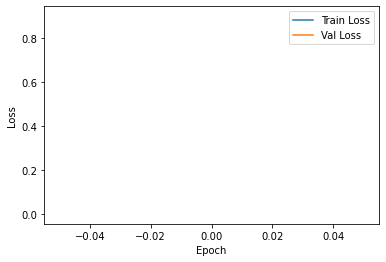

Training Progress:  10%|█         | 1/10 [00:06<00:58,  6.51s/it, Train Loss=0.9014, Val Loss=0.0000]


 Epoch 2/10
Train Loss: 0.0654


Training Progress:  10%|█         | 1/10 [00:12<00:58,  6.51s/it, Train Loss=0.0654, Val Loss=0.0002]

Val Loss: 0.0002


<Figure size 432x288 with 0 Axes>

Training Progress:  20%|██        | 2/10 [00:12<00:50,  6.27s/it, Train Loss=0.0654, Val Loss=0.0002]


 Epoch 3/10
Train Loss: 0.0194


Training Progress:  20%|██        | 2/10 [00:18<00:50,  6.27s/it, Train Loss=0.0194, Val Loss=0.0108]

Val Loss: 0.0108


<Figure size 432x288 with 0 Axes>

Training Progress:  30%|███       | 3/10 [00:18<00:43,  6.17s/it, Train Loss=0.0194, Val Loss=0.0108]


 Epoch 4/10
Train Loss: 0.0116


Training Progress:  30%|███       | 3/10 [00:24<00:43,  6.17s/it, Train Loss=0.0116, Val Loss=0.0029]

Val Loss: 0.0029


<Figure size 432x288 with 0 Axes>

Training Progress:  40%|████      | 4/10 [00:24<00:35,  5.98s/it, Train Loss=0.0116, Val Loss=0.0029]


 Epoch 5/10
Train Loss: 0.0086


Training Progress:  40%|████      | 4/10 [00:30<00:35,  5.98s/it, Train Loss=0.0086, Val Loss=0.0047]

Val Loss: 0.0047


<Figure size 432x288 with 0 Axes>

Training Progress:  50%|█████     | 5/10 [00:30<00:30,  6.05s/it, Train Loss=0.0086, Val Loss=0.0047]


 Epoch 6/10
Train Loss: 0.0065


Training Progress:  50%|█████     | 5/10 [00:36<00:30,  6.05s/it, Train Loss=0.0065, Val Loss=0.0040]

Val Loss: 0.0040


<Figure size 432x288 with 0 Axes>

Training Progress:  60%|██████    | 6/10 [00:36<00:23,  5.96s/it, Train Loss=0.0065, Val Loss=0.0040]


 Epoch 7/10
Train Loss: 0.0052


Training Progress:  60%|██████    | 6/10 [00:42<00:23,  5.96s/it, Train Loss=0.0052, Val Loss=0.0030]

Val Loss: 0.0030


<Figure size 432x288 with 0 Axes>

Training Progress:  70%|███████   | 7/10 [00:42<00:17,  5.95s/it, Train Loss=0.0052, Val Loss=0.0030]


 Epoch 8/10
Train Loss: 0.0039


Training Progress:  70%|███████   | 7/10 [00:47<00:17,  5.95s/it, Train Loss=0.0039, Val Loss=0.0028]

Val Loss: 0.0028


<Figure size 432x288 with 0 Axes>

Training Progress:  80%|████████  | 8/10 [00:47<00:11,  5.81s/it, Train Loss=0.0039, Val Loss=0.0028]


 Epoch 9/10
Train Loss: 0.0034


Training Progress:  80%|████████  | 8/10 [00:53<00:11,  5.81s/it, Train Loss=0.0034, Val Loss=0.0022]

Val Loss: 0.0022


<Figure size 432x288 with 0 Axes>

Training Progress:  90%|█████████ | 9/10 [00:53<00:05,  5.83s/it, Train Loss=0.0034, Val Loss=0.0022]


 Epoch 10/10
Train Loss: 0.0028


Training Progress:  90%|█████████ | 9/10 [00:59<00:05,  5.83s/it, Train Loss=0.0028, Val Loss=0.0016]

Val Loss: 0.0016


<Figure size 432x288 with 0 Axes>

Training Progress: 100%|██████████| 10/10 [00:59<00:00,  5.93s/it, Train Loss=0.0028, Val Loss=0.0016]


Final model checkpoint saved!
Training Completed!


In [58]:
train(model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE, EPOCHS)